# LangGraph Retrieval GroundCheck
기존의 RAG에 GroundChecker 기능을 추가하여 답변-문서 간에 관련성 여부를 확인합니다.

이번 튜토리얼에서는 `Upstage` 의 `UpstageGroundednessCheck` 기능을 사용하여 검증합니다.

필요에 따라, 직접 구현한 LLM 으로 GroundChecker를 수행할 수 있습니다.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [3]:
from rag.base import RetrieverChain

In [4]:
from rag.pdf import PDFRetrievalChain
pdf = PDFRetrievalChain(["./data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


# GraphSte
각 노드에서 다옴 노드로 전달되는 상태를 저장

In [10]:
from typing import TypedDict

class GraphState(TypedDict):
    question: str # 질문
    context: str # 문서의 검색 결과
    answer: str # 답변
    relevance: str # 문서의 관련성

In [11]:
from rag.utils import format_docs
from langchain_upstage import UpstageGroundednessCheck

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()
upstage_ground_checker.run(
    {
        "context": format_docs(
            pdf_retriever.invoke("삼성전자가 개발한 생성형 ai의 이름은?")
        ),
        "answer": " 삼성전자가 개발한 생성형 AI의이름은 빅스비 입니다"
    }
)

'notGrounded'

In [12]:
# 문서에서 검색하여 관련성 있는 문서를 찾는다.
def retrieve_document(state: GraphState) -> GraphState:
    retrived_docs = pdf_retriever.invoke(state["question"])
    return GraphState(context=format_docs(retrived_docs))

In [13]:
# chain을 사용하여 답변을 생성
def llm_answer(state:GraphState) -> GraphState:
    return GraphState(
        answer = pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        ),
        context = state["context"],
        question = state["question"]
    )

In [14]:
# 테스트용 더미 답변 생성 함수
def fake_llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer = "삼성전자가 개발한 생성형 ai의 이름은 빅스비ai입니다.",
        context = state["context"],
        question = state["question"]
    )

In [15]:
# 관령성 체크
def relevance_check(state: GraphState) -> GraphState:
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response,
        context=state["context"],
        answer=state["answer"],
        question=state["question"]
    )

In [16]:
# 관련성 체크 결과 답변
def is_relevant(state:GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

# 그래프 정의

In [17]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document) # 에이전트 노드 추가
workflow.add_node("llm_answer", llm_answer) # 정보 검색 노드 추가
#workflow.add_node("fake_llm_answer", fake_llm_answer)
workflow.add_node("relevance_check", relevance_check) # 관련성 체크 노드 추가

# 노드를 연결하는 엣지정의
workflow.add_edge("retrieve", "llm_answer")
workflow.add_edge("llm_answer", "relevance_check")

# 조건부 edge
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "관련성 O": END,
        "관련성 X": "retrieve",
        "확인불가": "retrieve"
    }
)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 그래프 시각화

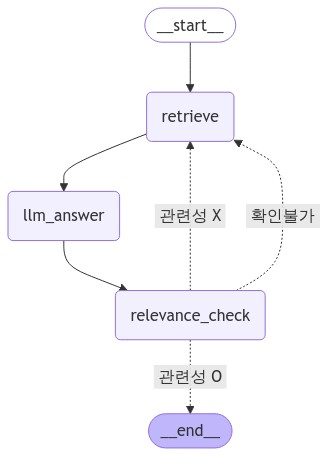

In [18]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

# 그래프 출력

In [19]:
from langchain_core.runnables import RunnableConfig
# recursion_limit 재귀한도(반복 횟수)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력
inputs = GraphState(question="삼성전자가 개발한 생성형 AI의 이름은?")

In [20]:
import pprint
from langgraph.errors import GraphRecursionError

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍.
# 스트리밍된 출력에서 각 노드의 결과를 순차적으로 처리. key는 노드의 이름을 나타내고, value는 그 노드의 출력값.
# 루프는 노드의 출력인 value에서 구체적인 출력 내용을 다시 순차적으로 출력합니다. 이때 k는 출력의 키, v는 출력 값
try:
    for output in app.stream(inputs, config=config):
        for key, value in output.items():
            pprint.pprint(f"[NODE] {key}") # 각 노드의 이름 출력
            for k, v in value.items():
                pprint.pprint(f"{k} {v}")
            pprint.pprint("==="*10)
except GraphRecursionError as e: #ERROR 처리
    pprint.pprint(f"Recursion linit rechead: {e}")

'[NODE] retrieve'
('context <document><content>SPRi AI Brief |\n'
 '2023-12월호\n'
 '삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\n'
 'KEY Contents\n'
 'n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\n'
 'AI 모델 ‘삼성 가우스’를 공개\n'
 'n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n'
 '삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n'
 '£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원\n'
 'n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델\n'
 '‘삼성 가우스’를 최초 공개\n'
 '∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에\n'
 '최적화된 크기의 모델 선택이 가능\n'
 '∙ 삼성 가우스는 라이선스나 개인정보를 침해하지 않는 안전한 데이터를 통해 학습되었으며,\n'
 '온디바이스에서 작동하도록 설계되어 외부로 사용자의 정보가 유출되지 않는 장점을 보유\n'
 '∙ 삼성전자는 삼성 가우스를 활용한 온디바이스 AI 기술도 소개했으며, 생성 AI 모델을 다양한 제품에\n'
 '단계적으로 탑재할 계획\n'
 'n 삼성 가우스는 △텍스트를 생성하는 언어모델 △코드를 생성하는 코드 모델 △이미지를 생성하는\n'
 '이미지 모델의 3개 모델로 구성\n'
 '∙ 언어 모델은 클라우드와 온디바이스 대상 다양한 모델로 구성되며, 메일 작성, 문서 요약, 번역 업무의\n'
 '처리를 지원\n'
 '∙ 코드 모델 기반의 AI 코딩 어시스턴트 ‘코드아이(code.i)’는 대화형 인터페이스로 서비스를 제공하며\n'
 '사내 소프트웨어 개발에 최적화\n'
 '∙ 이미지 모델은 창의적인 이미지를

In [21]:
print("Question: \t", output["relevance_check"]["question"])
print("Answer: \t", output["relevance_check"]["answer"])
print("Relevance: \t", output["relevance_check"]["relevance"])

Question: 	 삼성전자가 개발한 생성형 AI의 이름은?
Answer: 	 삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다. 이 AI는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동할 수 있도록 설계되었습니다. 출처: ./data/SPRI_AI_Brief_2023년12월호_F.pdf, 페이지 10.
Relevance: 	 grounded
